In [14]:
import numpy as np
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings

from scipy.interpolate import interp1d

In [15]:
warnings.filterwarnings('ignore')

In [16]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Data')
data = gpd.read_file('Data_combined.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')
mandal_boundaries = mandal_boundaries.reset_index()

In [17]:
data['ModifiedDateTime'] = pd.to_datetime(data['ModifiedDateTime'])
data['Month'] = data['ModifiedDateTime'].dt.month
data = data.sort_values(by='ModifiedDateTime')
data.head()

,index,Mandal_Nam,Dist_Name,ModifiedDateTime,NO2,PM2.5,Year,Month,Crops,Trees,...,PRE_percentile_90_lagged,PRE_median_lagged,Chromic Luvisols,Chromic Vertisols,Eutric Nitosols,Lithosols,Pellic Luvisols,Plinthic Luvisols,Vertic Cambisols,geometry
0,0,Abdullapurmet,Rangareddy,2016-01-01,238.435040,47.675000,2016,1,84.9980,5.2694,...,0.000000,0.000000,1,0,0,0,0,0,0,"POLYGON ((78.59021 17.34506, 78.59009 17.34537..."
10404,289,Mahabubnagar_Urban,Mahabubnagar,2016-01-01,175.688976,38.924999,2016,1,37.3555,5.9588,...,0.000000,0.000000,0,0,0,0,0,0,1,"POLYGON ((78.01045 16.79459, 78.01346 16.79360..."
19728,548,Yacharam,Rangareddy,2016-01-01,153.543310,37.744444,2016,1,142.5153,8.1216,...,0.000000,0.000000,1,0,0,0,0,0,0,"POLYGON ((78.67716 17.12881, 78.67731 17.12878..."
2016,56,Bheemaram,Mancherial,2016-01-01,382.381889,42.750000,2016,1,62.1308,67.1091,...,0.298574,0.281212,1,0,0,0,0,0,0,"POLYGON ((79.63225 18.94709, 79.63487 18.94602..."
10368,288,Mahabubabad,Mahabubabad,2016-01-01,235.039371,39.240000,2016,1,199.9399,5.4553,...,0.172625,0.000000,1,0,0,0,0,0,0,"MULTIPOLYGON (((79.94889 17.51417, 79.94889 17..."


In [19]:
data.columns

Index(['index', 'Mandal_Nam', 'Dist_Name', 'ModifiedDateTime', 'NO2', 'PM2.5',
       'Year', 'Month', 'Crops', 'Trees', 'Built Area', 'POP_mean', 'RWI_mean',
       'RWI_max', 'RWI_min', 'RWI_percentile_90', 'Season', 'POP_median',
       'RWI_median', 'time_to_rur_median', 'Paddy', 'Maize', 'Soybean',
       'Cotton', 'Chillies', 'Turmeric', 'SSM_lagged', 'ST_lagged',
       'ST_max_lagged', 'ST_min_lagged', 'ST_percentile_90_lagged',
       'ST_median_lagged', 'BA_lagged', 'AOT_lagged', 'AOT_max_lagged',
       'AOT_min_lagged', 'AOT_percentile_90_lagged', 'AOT_median_lagged',
       'PRE_lagged', 'PRE_max_lagged', 'PRE_min_lagged',
       'PRE_percentile_90_lagged', 'PRE_median_lagged', 'Chromic Luvisols',
       'Chromic Vertisols', 'Eutric Nitosols', 'Lithosols', 'Pellic Luvisols',
       'Plinthic Luvisols', 'Vertic Cambisols', 'geometry'],
      dtype='object')

In [22]:
units = ['Crops', 'Trees', 'Built Area', 'NO2', 'PM2.5', 'Paddy', 'Maize', 'Soybean', 'Cotton', 'Chillies', 'Turmeric', 'SSM_lagged', 'ST_lagged', 'ST_max_lagged', 'ST_percentile_90_lagged', 'ST_min_lagged', 'ST_median_lagged', 'BA_lagged', 'AOT_lagged', 'AOT_min_lagged', 'AOT_median_lagged', 'AOT_max_lagged', 'AOT_percentile_90_lagged',]

for i in units:
    print(i + ' has ' + str(data[i].isnull().sum()) + ' missing values.')

Crops has 0 missing values.
Trees has 0 missing values.
Built Area has 0 missing values.
NO2 has 0 missing values.
PM2.5 has 0 missing values.
Paddy has 646 missing values.
Maize has 646 missing values.
Soybean has 646 missing values.
Cotton has 646 missing values.
Chillies has 646 missing values.
Turmeric has 646 missing values.
SSM_lagged has 1776 missing values.
ST_lagged has 120 missing values.
ST_max_lagged has 120 missing values.
ST_percentile_90_lagged has 120 missing values.
ST_min_lagged has 120 missing values.
ST_median_lagged has 120 missing values.
BA_lagged has 0 missing values.
AOT_lagged has 2192 missing values.
AOT_min_lagged has 2192 missing values.
AOT_median_lagged has 2192 missing values.
AOT_max_lagged has 2192 missing values.
AOT_percentile_90_lagged has 2192 missing values.


## Dropping all mandals of which no one data type is available

In [23]:

#Note that we do not have crop type values for all mandals, they have zero's during non-season but for complete picture we remove these mandals completely
missing_mandal_crop_types = [13, 34, 37, 220, 265, 579, 584, 585, 586, 587, 588, 591] #Can be found in Date_pre_combiner.ipynb

#No soil temperature for this mandal available
#missing_mandal_ST = [79]

#We also need to remove the non-seasonal mandals
data = data[~data['index'].isin(missing_mandal_crop_types)]
#data = data[~data['index'].isin(missing_mandal_ST)]

# Test Run all values 

In [24]:
#First just drop all NaNs
data_final = data.dropna()

## Dropping values that are hard to interpolate

In [64]:
#Crop data hard to interpolate due to only 2 observations or less
data = data[data['Paddy'].notna()]
#Soil Moisture hard to interpolate because in the first year everywhere the first three months are missing
data = data[data['SSM_lagged'].notna()]

In [65]:
for i in units:
    print(i + ' has ' + str(data[i].isnull().sum()) + ' missing values.')

Crops has 0 missing values.
Trees has 0 missing values.
Built Area has 0 missing values.
NO2 has 0 missing values.
PM2.5 has 0 missing values.
Paddy has 0 missing values.
Maize has 0 missing values.
Soybean has 0 missing values.
Cotton has 0 missing values.
Chillies has 0 missing values.
Turmeric has 0 missing values.
SSM_lagged has 0 missing values.
ST_lagged has 128 missing values.
ST_max_lagged has 128 missing values.
ST_percentile_90_lagged has 128 missing values.
BA_lagged has 0 missing values.
AOT_lagged has 2106 missing values.
AOT_max_lagged has 2106 missing values.
AOT_percentile_90_lagged has 2106 missing values.


In [68]:
data = data.sort_values(by='ModifiedDateTime')
len(data)

18605

# Filling Missing Values of SSM and ST

Filling ST is possible linearly see plots:

In [70]:
missing_STL_indexes = data[data['ST_lagged'].isnull()]['index'].unique()
df_ST_missing = data[data['index'].isin(missing_STL_indexes)]

data['test'] = data['ST_lagged'].interpolate(method = 'linear')

#for index in missing_STL_indexes:
#    df_mandal_ST_missing = df_ST_missing[df_ST_missing['index']==index]
#    df_mandal_ST_missing['ST_lagged_filled'] = df_mandal_ST_missing['ST_lagged'].interpolate(method = 'linear')
#    plt.plot(df_mandal_ST_missing['ModifiedDateTime'], df_mandal_ST_missing['ST_lagged'], color='red', marker='o')
#    plt.plot(df_mandal_ST_missing['ModifiedDateTime'],  df_mandal_ST_missing['ST_lagged_filled'], color='blue', linestyle='--')
#    plt.legend(['data', 'test'], loc='best')
#    plt.xticks(rotation=45, ha='right')
#    plt.ylabel('Soil Temperature (degrees Celcius)')
#    plt.xlabel('Date')
#    plt.title('Filling Missing Values Mandal ' + df_mandal_ST_missing['Mandal_Nam'].iloc[0])
#    plt.show()



In [69]:
for i in units:
    print(i + ' has ' + str(data[i].isnull().sum()) + ' missing values.')

Crops has 0 missing values.
Trees has 0 missing values.
Built Area has 0 missing values.
NO2 has 0 missing values.
PM2.5 has 0 missing values.
Paddy has 0 missing values.
Maize has 0 missing values.
Soybean has 0 missing values.
Cotton has 0 missing values.
Chillies has 0 missing values.
Turmeric has 0 missing values.
SSM_lagged has 0 missing values.
ST_lagged has 128 missing values.
ST_max_lagged has 128 missing values.
ST_percentile_90_lagged has 128 missing values.
BA_lagged has 0 missing values.
AOT_lagged has 2106 missing values.
AOT_max_lagged has 2106 missing values.
AOT_percentile_90_lagged has 2106 missing values.


In [60]:
del data['test'] 

In [7]:
#Also drop mandals that do not have all observations
data_points_count = data_final.groupby('index')['Year'].count().reset_index()
data_points_count = data_points_count[data_points_count['Year']==33]['index'].to_list()

data_full_mandals = data_final[data_final['index'].isin(data_points_count)]

In [27]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Model\\Data')
len(data_final)
data_final.to_file('Data_final.geojson', driver='GeoJSON')

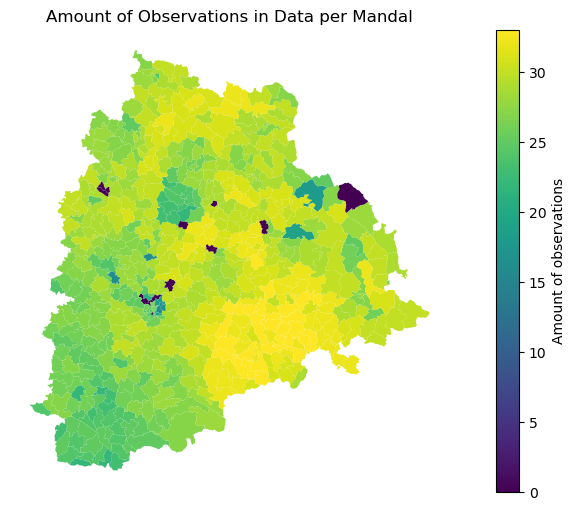

In [25]:
data_gr = data_final.groupby('index')['Year'].count().reset_index()
data_miss = pd.merge(data_gr, mandal_boundaries[['index', 'geometry']], on='index', how='right')
data_miss['Year'] = data_miss['Year'].fillna(0)

data_miss = gpd.GeoDataFrame(data_miss, geometry = data_miss.geometry, crs = {'init': 'epsg:4326'}) 

data_miss.plot(column = 'Year', legend=True, figsize = [12,6], legend_kwds = {'label': 'Amount of observations'}, )
plt.axis('off')
plt.title('Amount of Observations in Data per Mandal')
plt.show()

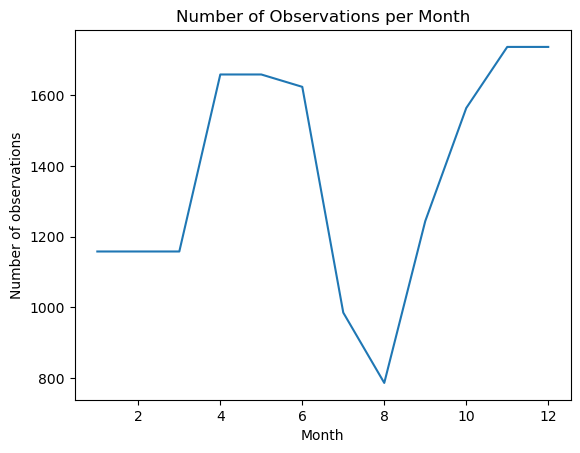

In [26]:
data_per_month = data_final.groupby('Month')['Year'].count().reset_index()

plt.plot(data_per_month['Month'], data_per_month['Year'])
plt.xlabel('Month')
plt.ylabel('Number of observations')
plt.title('Number of Observations per Month')
plt.show()

In [10]:
data_full_mandals.to_file('Data_full_mandals.geojson', driver='GeoJSON')

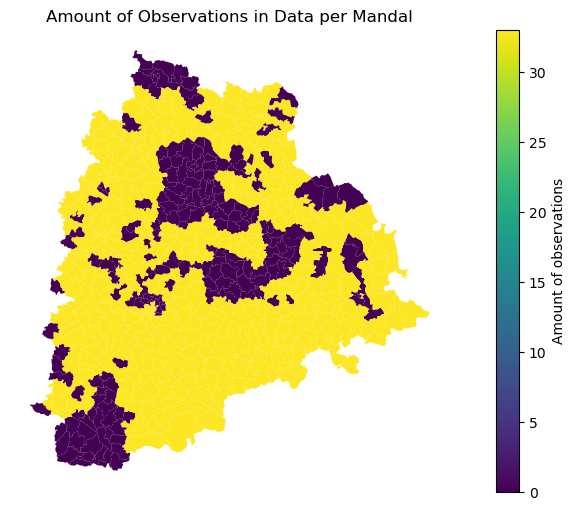

In [11]:
data_gr = data_full_mandals.groupby('index')['Year'].count().reset_index()
data_miss = pd.merge(data_gr, mandal_boundaries[['index', 'geometry']], on='index', how='right')
data_miss['Year'] = data_miss['Year'].fillna(0)

data_miss = gpd.GeoDataFrame(data_miss,geometry = data_miss.geometry, crs = {'init': 'epsg:4326'}) 

data_miss.plot(column = 'Year', legend=True, figsize = [12,6], legend_kwds = {'label': 'Amount of observations'}, )
plt.axis('off')
plt.title('Amount of Observations in Data per Mandal')
plt.show()